In [1]:
import keras
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import SVG
from IPython.display import display

import random

Using TensorFlow backend.


In [2]:
size = 100
def appendSize():
    return str(size) + 'x' + str(size)

# Load image data
imgdat_glass = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_glass_' + appendSize() + '.npy')
imgdat_paper = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_paper_' + appendSize() + '.npy')
imgdat_cardboard = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_cardboard_' + appendSize() + '.npy')
imgdat_plastic = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_plastic_' + appendSize() + '.npy')
imgdat_metal = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_metal_' + appendSize() + '.npy')
imgdat_trash = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_trash_' + appendSize() + '.npy')

# Make sure the data loaded correctly
print(imgdat_glass.shape)
print(imgdat_paper.shape)
print(imgdat_cardboard.shape)
print(imgdat_plastic.shape)
print(imgdat_metal.shape)
print(imgdat_trash.shape)

# Load in the labels and convert to one-hot encoding
with open('/nfshome/sandbox/TrashNet-Dataset/labels.csv', 'r', encoding = 'utf-8') as f:
    labels = f.read().split(',')
Y = keras.utils.to_categorical(labels)

print(Y.shape)

(501, 100, 100, 3)
(594, 100, 100, 3)
(403, 100, 100, 3)
(482, 100, 100, 3)
(410, 100, 100, 3)
(137, 100, 100, 3)
(2527, 6)


In [3]:
# Split labels up by category
imgdat_lens = [imgdat_glass.shape[0], imgdat_paper.shape[0], imgdat_cardboard.shape[0],
               imgdat_plastic.shape[0], imgdat_metal.shape[0], imgdat_trash.shape[0]]
Y_categories = []
index_start = 0
for imgdat_len in imgdat_lens:
    index_end = index_start + imgdat_len
    Y_categories = Y_categories + [Y[index_start : index_end]]
    index_start = index_end

# Shuffle all image data
imgdat_glass = imgdat_glass[np.random.permutation(len(imgdat_glass))]
imgdat_paper = imgdat_paper[np.random.permutation(len(imgdat_paper))]
imgdat_cardboard = imgdat_cardboard[np.random.permutation(len(imgdat_cardboard))]
imgdat_plastic = imgdat_plastic[np.random.permutation(len(imgdat_plastic))]
imgdat_metal = imgdat_metal[np.random.permutation(len(imgdat_metal))]
imgdat_trash = imgdat_trash[np.random.permutation(len(imgdat_trash))]

# Split image categories into training and testing sets
def getHalfLen(img_set):
    return int(len(img_set) / 2)

training_glass = imgdat_glass[ : getHalfLen(imgdat_glass)]
training_glass_labels = Y_categories[0][ : getHalfLen(Y_categories[0])]
training_paper = imgdat_paper[ : getHalfLen(imgdat_paper)]
training_paper_labels = Y_categories[1][ : getHalfLen(Y_categories[1])]
training_cardboard = imgdat_cardboard[ : getHalfLen(imgdat_cardboard)]
training_cardboard_labels = Y_categories[2][ : getHalfLen(Y_categories[2])]
training_plastic = imgdat_plastic[ : getHalfLen(imgdat_plastic)]
training_plastic_labels = Y_categories[3][ : getHalfLen(Y_categories[3])]
training_metal = imgdat_metal[ : getHalfLen(imgdat_metal)]
training_metal_labels = Y_categories[4][ : getHalfLen(Y_categories[4])]
training_trash = imgdat_trash[ : getHalfLen(imgdat_trash)]
training_trash_labels = Y_categories[5][ : getHalfLen(Y_categories[5])]

testing_glass = imgdat_glass[getHalfLen(imgdat_glass) : ]
testing_glass_labels = Y_categories[0][getHalfLen(Y_categories[0]) : ]
testing_paper = imgdat_paper[getHalfLen(imgdat_paper) : ]
testing_paper_labels = Y_categories[1][getHalfLen(Y_categories[1]) : ]
testing_cardboard = imgdat_cardboard[getHalfLen(imgdat_cardboard) : ]
testing_cardboard_labels = Y_categories[2][getHalfLen(Y_categories[2]) : ]
testing_plastic = imgdat_plastic[getHalfLen(imgdat_plastic) : ]
testing_plastic_labels = Y_categories[3][getHalfLen(Y_categories[3]) : ]
testing_metal = imgdat_metal[getHalfLen(imgdat_metal) : ]
testing_metal_labels = Y_categories[4][getHalfLen(Y_categories[4]) : ]
testing_trash = imgdat_trash[getHalfLen(imgdat_trash) : ]
testing_trash_labels = Y_categories[5][getHalfLen(Y_categories[5]) : ]

# Concatenate into training and testing sets
X_train = np.concatenate((training_glass, training_paper, training_cardboard,
                          training_plastic, training_metal, training_trash))
Y_train = np.concatenate((training_glass_labels, training_paper_labels, training_cardboard_labels,
                          training_plastic_labels, training_metal_labels, training_trash_labels))

X_test = np.concatenate((testing_glass, testing_paper, testing_cardboard,
                         testing_plastic, testing_metal, testing_trash))
Y_test = np.concatenate((testing_glass_labels, testing_paper_labels, testing_cardboard_labels,
                         testing_plastic_labels, testing_metal_labels, testing_trash_labels))

# Shuffle training and testing sets
permute = np.random.permutation(len(X_train))
X_train = X_train[permute]
Y_train = Y_train[permute]

permute = np.random.permutation(len(X_test))
X_test = X_test[permute]
Y_test = Y_test[permute]

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)
print('Combined X: ', X_train.shape[0] + X_test.shape[0])

X_train shape:  (1262, 100, 100, 3)
Y_train shape:  (1262, 6)
X_test shape:  (1265, 100, 100, 3)
Y_test shape:  (1265, 6)
Combined X:  2527


In [5]:
# Mean-center all image data
#X = (X - X.mean()) / X.std()
for n in range(0, X_train.shape[0]):
    X_train[n] = (X_train[n] - X_train[n].mean()) / X_train[n].std()

for n in range(0, X_test.shape[0]):
    X_test[n] = (X_test[n] - X_test[n].mean()) / X_test[n].std()

model = keras.Sequential()

# Bottleneck to keep parameters low
model.add(keras.layers.Conv2D(24, kernel_size = (1, 1), # squeeze
                              activation = 'relu',
                              bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None),
                              kernel_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None),
                              input_shape = [size, size, 3]))

model.add(keras.layers.Conv2D(24, kernel_size = (3, 3), # map 
                              strides = (2, 2),
                              activation = 'relu',
                              bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None),
                              kernel_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None)))

model.add(keras.layers.Conv2D(32, kernel_size = (1, 1), # expand
                             activation = 'relu',
                             bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None), 
                             kernel_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None)))
model.add(keras.layers.BatchNormalization(momentum = 0.99))

model.add(keras.layers.SpatialDropout2D(rate = 0.25))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(Y.shape[1] * 2, activation = 'tanh'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(Y.shape[1], activation = 'softmax'))

model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.0001, amsgrad = True),
             metrics = ['accuracy'])

model.summary()

model = keras.Sequential()

#model.add(keras.layers.Conv2D(32, kernel_size = (1, 1),
#                             activation = 'relu',
#                             input_shape = [size, size, 3]))
#model.add(keras.layers.SpatialDropout2D(rate = 0.25))
model.add(keras.layers.Conv2D(32, kernel_size = (3, 3),
                             strides = (2, 2),
                             activation = 'relu',
                             input_shape = [size, size, 3]))
model.add(keras.layers.SpatialDropout2D(rate = 0.25))
#model.add(keras.layers.Conv2D(64, kernel_size = (1, 1),
#                             activation = 'relu'))
#model.add(keras.layers.SpatialDropout2D(rate = 0.25))
model.add(keras.layers.normalization.BatchNormalization(momentum = 0.99))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(Y.shape[1] * 4, activation = 'tanh'))
model.add(keras.layers.Dense(Y.shape[1] * 3, activation = 'tanh'))
model.add(keras.layers.Dense(Y.shape[1] * 2, activation = 'tanh'))
model.add(keras.layers.Dense(Y.shape[1], activation = 'softmax'))

model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.0001, amsgrad = True),
              metrics = ['accuracy'])
model.summary()

net_in = keras.layers.Input(shape = [size, size, 3])

# Send input to two different convolving layers: one vertical and one horizontal
conv_horiz = keras.layers.Conv2D(16, kernel_size = (4, 2), strides = (2, 2))(net_in)
conv_verti = keras.layers.Conv2D(16, kernel_size = (2, 4), strides = (2, 2))(net_in)

# Normalize
bNorm_horiz = keras.layers.normalization.BatchNormalization()(conv_horiz)
bNorm_verti = keras.layers.normalization.BatchNormalization()(conv_verti)

# Activations
conv_horiz_activ = keras.layers.ReLU()(bNorm_horiz)
conv_verti_activ = keras.layers.ReLU()(bNorm_verti)

# Dropouts
conv_horiz_dropout = keras.layers.SpatialDropout2D(0.25)(conv_horiz_activ)
conv_verti_dropout = keras.layers.SpatialDropout2D(0.25)(conv_verti_activ)


# Convolve into square shape
conv_horiz_reshaped = keras.layers.Conv2D(32, kernel_size = (2, 4), strides = (2, 2))(conv_horiz_activ)
conv_verti_reshaped = keras.layers.Conv2D(32, kernel_size = (4, 2), strides = (2, 2))(conv_verti_activ)

# Normalize again
bNorm_horiz_reshaped = keras.layers.normalization.BatchNormalization()(conv_horiz_reshaped)
bNorm_verti_reshaped = keras.layers.normalization.BatchNormalization()(conv_verti_reshaped)

# Activations again
conv_horiz_reshaped_activ = keras.layers.ReLU()(bNorm_horiz_reshaped)
conv_verti_reshaped_activ = keras.layers.ReLU()(bNorm_verti_reshaped)

# Dropouts again
conv_horiz_reshaped_dropout = keras.layers.SpatialDropout2D(0.25)(conv_horiz_reshaped_activ)
conv_verti_reshaped_dropout = keras.layers.SpatialDropout2D(0.25)(conv_verti_reshaped_activ)

# Merge
merged = keras.layers.concatenate([conv_horiz_reshaped_activ, conv_verti_reshaped_activ])

# Max pooling and flatten
pooled = keras.layers.MaxPooling2D(2, 2)(merged)
flat = keras.layers.Flatten()(pooled)

# Output
net_out = keras.layers.Dense(Y.shape[1], activation = 'softmax')(flat)

# Create model and compile
model = keras.Model(net_in, net_out)
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.001, amsgrad = True),
             metrics = ['accuracy'])
model.summary()

img_in = keras.layers.Input(shape = [size, size, 3])

# Split and convolve
'''
conv_horiz = keras.layers.Conv2D(16, kernel_size = (4, 2), padding = 'same')(img_in)
conv_horiz = keras.layers.LeakyReLU()(conv_horiz)
conv_horiz = keras.layers.Conv2D(32, kernel_size = (4, 2), padding = 'same')(conv_horiz)
conv_horiz = keras.layers.LeakyReLU()(conv_horiz)
conv_horiz = keras.layers.SpatialDropout2D(0.1)(conv_horiz)

conv_verti = keras.layers.Conv2D(16, kernel_size = (2, 4), padding = 'same')(img_in)
conv_verti = keras.layers.LeakyReLU()(conv_verti)
conv_verti = keras.layers.Conv2D(32, kernel_size = (2, 4), padding = 'same')(conv_verti)
conv_verti = keras.layers.LeakyReLU()(conv_verti)
conv_verti = keras.layers.SpatialDropout2D(0.1)(conv_verti)
'''

conv_small = keras.layers.Conv2D(16, kernel_size = (1, 1))(img_in)
conv_small = keras.layers.Conv2D(16, kernel_size = (2, 2), padding = 'same')(conv_small)
conv_small = keras.layers.LeakyReLU()(conv_small)
conv_small = keras.layers.Conv2D(32, kernel_size = (1, 1))(conv_small)
conv_small = keras.layers.Conv2D(32, kernel_size = (2, 2), padding = 'same')(conv_small)
conv_small = keras.layers.LeakyReLU()(conv_small)
conv_small = keras.layers.SpatialDropout2D(0.1)(conv_small)

conv_large = keras.layers.Conv2D(16, kernel_size = (1, 1))(img_in)
conv_large = keras.layers.Conv2D(16, kernel_size = (4, 4), padding = 'same')(conv_large)
conv_large = keras.layers.LeakyReLU()(conv_large)
conv_large = keras.layers.Conv2D(32, kernel_size = (1, 1))(conv_large)
conv_large = keras.layers.Conv2D(32, kernel_size = (4, 4), padding = 'same')(conv_large)
conv_large = keras.layers.LeakyReLU()(conv_large)
conv_large = keras.layers.SpatialDropout2D(0.1)(conv_large)

# Merge, dropout, and pool
conv_merged = keras.layers.concatenate([conv_small, conv_large])
conv_merged = keras.layers.SpatialDropout2D(0.5)(conv_merged)
conv_merged = keras.layers.MaxPooling2D(2, 2)(conv_merged)

# Dense hidden and network output
dense = keras.layers.Flatten()(conv_merged)
dense = keras.layers.Dropout(0.25)(dense)
#dense = keras.layers.Dense(Y.shape[1] * 3, activation = 'tanh')(dense)
net_out = keras.layers.Dense(Y.shape[1], activation = 'softmax')(dense)

# Create model and compile
model = keras.Model(img_in, net_out)
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adam(lr = 0.001, amsgrad = True),
              metrics = ['accuracy'])
model.summary()

img_in = keras.layers.Input(shape = [size, size, 3])

# Convolutions of different sizes
conv_small = keras.layers.Conv2D(16, kernel_size = (4, 4), padding = 'same')(img_in)
conv_small = keras.layers.LeakyReLU()(conv_small)
conv_small = keras.layers.SpatialDropout2D(0.25)(conv_small)

conv_large = keras.layers.Conv2D(16, kernel_size = (8, 8), padding = 'same')(img_in)
conv_large = keras.layers.LeakyReLU()(conv_large)
conv_large = keras.layers.SpatialDropout2D(0.25)(conv_large)

# Merge, dropout, pool
conv_merged = keras.layers.concatenate([conv_small, conv_large])
conv_merged = keras.layers.SpatialDropout2D(0.5)(conv_merged)
conv_merged = keras.layers.MaxPooling2D(2, 2)(conv_merged)

# Split and convolve, but with smaller filters
conv_small = keras.layers.Conv2D(32, kernel_size = (2, 2), padding = 'same')(img_in)
conv_small = keras.layers.LeakyReLU()(conv_small)
conv_small = keras.layers.SpatialDropout2D(0.25)(conv_small)

conv_large = keras.layers.Conv2D(32, kernel_size = (4, 4), padding = 'same')(img_in)
conv_large = keras.layers.LeakyReLU()(conv_large)
conv_large = keras.layers.SpatialDropout2D(0.25)(conv_large)

# Merge, dropout, pool
conv_merged = keras.layers.concatenate([conv_small, conv_large])
conv_merged = keras.layers.SpatialDropout2D(0.5)(conv_merged)
conv_merged = keras.layers.MaxPooling2D(2, 2)(conv_merged)

# Dense hidden
dense = keras.layers.Flatten()(conv_merged)
dense = keras.layers.Dense(Y.shape[1] * 4, activation = 'tanh')(dense)
net_out = keras.layers.Dense(Y.shape[1], activation = 'softmax')(dense)

# Create model and compile
model = keras.Model(img_in, net_out)
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adam(lr = 0.001, amsgrad = True),
              metrics = ['accuracy'])
model.summary()

img_in = keras.layers.Input(shape = [size, size, 3])

conv_tiny = keras.layers.Conv2D(16, kernel_size = (1, 1))(img_in)
conv_tiny = keras.layers.ReLU()(keras.layers.normalization.BatchNormalization()(conv_tiny))
conv_small = keras.layers.Conv2D(16, kernel_size = (2, 2), padding = 'same')(keras.layers.Conv2D(16, kernel_size = (1, 1))(img_in))
conv_small = keras.layers.ReLU()(keras.layers.normalization.BatchNormalization()(conv_small))
conv_large = keras.layers.Conv2D(16, kernel_size = (4, 4), padding = 'same')(keras.layers.Conv2D(16, kernel_size = (1, 1))(img_in))
conv_large = keras.layers.ReLU()(keras.layers.normalization.BatchNormalization()(conv_large))

img_in = keras.layers.Input(shape = [size, size, 3])

conv_large = keras.layers.Conv2D(24, kernel_size = (4,  4), strides = (2, 2), activation = 'relu')(img_in)
conv_small = keras.layers.Conv2D(24, kernel_size = (2, 2), activation = 'relu')(img_in)

spDropout_large = keras.layers.SpatialDropout2D(0.5)(conv_large)
spDropout_small = keras.layers.SpatialDropout2D(0.5)(conv_small)

bNorm_large = keras.layers.normalization.BatchNormalization()(spDropout_large)
bNorm_small = keras.layers.normalization.BatchNormalization()(spDropout_small)

pool_large = keras.layers.MaxPooling2D(2, 2)(bNorm_large)
pool_small = keras.layers.MaxPooling2D(2, 2)(bNorm_small)

flat_large = keras.layers.Flatten()(pool_large)
flat_small = keras.layers.Flatten()(pool_small)

dense_large = keras.layers.Dense(Y.shape[1], activation = 'tanh')(flat_large)
dense_small = keras.layers.Dense(Y.shape[1], activation = 'tanh')(flat_small)

combined = keras.layers.concatenate([dense_large, dense_small])
net_out = keras.layers.Dense(Y.shape[1], activation = 'softmax')(combined)

model = keras.Model(img_in, net_out)
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.0001, amsgrad = True),
             metrics = ['accuracy'])
model.summary()

img_in = keras.layers.Input(shape = [size, size, 3])

conv = keras.layers.Conv2D(24, kernel_size = (1, 1), activation = 'relu')(img_in)
conv = keras.layers.Conv2D(24, kernel_size = (2, 2), activation = 'relu')(conv)
conv = keras.layers.Conv2D(48, kernel_size = (1, 1), activation = 'relu')(conv)
conv = keras.layers.SpatialDropout2D(0.25)(conv)
conv = keras.layers.MaxPooling2D(2, 2)(conv)
conv = keras.layers.Conv2D(48, kernel_size = (1, 1), activation = 'relu')(conv)
conv = keras.layers.Conv2D(48, kernel_size = (2, 2), activation = 'relu')(conv)
conv = keras.layers.Conv2D(96, kernel_size = (1, 1), activation = 'relu')(conv)
conv = keras.layers.SpatialDropout2D(0.25)(conv)
conv = keras.layers.MaxPooling2D(2, 2)(conv)

dense = keras.layers.Flatten()(conv)
dense = keras.layers.Dense(Y.shape[1] * 5, activation = 'tanh')(dense)
dense = keras.layers.Dense(Y.shape[1] * 3, activation = 'tanh')(dense)
net_out = keras.layers.Dense(Y.shape[1], activation = 'softmax')(dense)

model = keras.Model(img_in, net_out)
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.001, amsgrad = True),
             metrics = ['accuracy'])
model.summary()

In [59]:
kernel_size = 3

def to_grayscale(img_tensor):
    # Using luminosity formula, which weights green more heavily since human eyes are more senstive to green
    return (0.21 * img_tensor[:, :, :, :1]) + (0.72 * img_tensor[:, :, :, 1:2]) + (0.07 * img_tensor[:, :, :, -1:])

img_in = keras.layers.Input(shape = [size, size, 3])

# Add noise to the input
img = keras.layers.GaussianNoise(0.3)(img_in)
img = keras.layers.MaxPooling2D(2, 2)(img)

# Grayscale convolutions
conv_gsc = keras.layers.Lambda(to_grayscale)(img) # Convert to grayscale w/ luminosity formula
conv_gsc = keras.layers.Conv2D(32, kernel_size = (kernel_size, kernel_size))(conv_gsc)
conv_gsc = keras.layers.ELU()(conv_gsc)
conv_gsc = keras.layers.Conv2D(32, kernel_size = (kernel_size, kernel_size))(conv_gsc)
conv_gsc = keras.layers.ELU()(conv_gsc)
#conv_gsc = keras.layers.SpatialDropout2D(0.1)(conv_gsc)
conv_gsc = keras.layers.MaxPooling2D(2, 2)(conv_gsc)

# Color convolutions
conv_rgb = keras.layers.Conv2D(32, kernel_size = (kernel_size, kernel_size))(img)
conv_rgb = keras.layers.ELU()(conv_rgb)
conv_rgb = keras.layers.Conv2D(32, kernel_size = (kernel_size, kernel_size))(conv_rgb)
conv_rgb = keras.layers.ELU()(conv_rgb)
#conv_rgb = keras.layers.SpatialDropout2D(0.1)(conv_rgb)
conv_rgb = keras.layers.MaxPooling2D(2, 2)(conv_rgb)

# Mix both together and convolve
conv_merged = keras.layers.concatenate([conv_gsc, conv_rgb])
conv_merged = keras.layers.Conv2D(64, kernel_size = (kernel_size, kernel_size))(conv_merged)
conv_merged = keras.layers.ELU()(conv_merged)
conv_merged = keras.layers.Conv2D(64, kernel_size = (kernel_size, kernel_size))(conv_merged)
conv_merged = keras.layers.ELU()(conv_merged)
#conv_merged = keras.layers.SpatialDropout2D(0.1)(conv_merged)
conv_merged = keras.layers.MaxPooling2D(2, 2)(conv_merged)

# Convolve with just grayscale
conv_gsc = keras.layers.Conv2D(64, kernel_size = (kernel_size, kernel_size))(conv_gsc)
conv_gsc = keras.layers.ELU()(conv_gsc)
conv_gsc = keras.layers.Conv2D(64, kernel_size = (kernel_size, kernel_size))(conv_gsc)
conv_gsc = keras.layers.ELU()(conv_gsc)
#conv_gsc = keras.layers.SpatialDropout2D(0.1)(conv_gsc)
conv_gsc = keras.layers.MaxPooling2D(2, 2)(conv_gsc)

# Convolve with just color
conv_rgb = keras.layers.Conv2D(64, kernel_size = (kernel_size, kernel_size))(conv_rgb)
conv_rgb = keras.layers.ELU()(conv_rgb)
conv_rgb = keras.layers.Conv2D(64, kernel_size = (kernel_size, kernel_size))(conv_rgb)
conv_rgb = keras.layers.ELU()(conv_rgb)
conv_rgb = keras.layers.SpatialDropout2D(0.1)(conv_rgb)
conv_rgb = keras.layers.MaxPooling2D(2, 2)(conv_rgb)

# Merge all
conv_merged = keras.layers.concatenate([conv_gsc, conv_rgb, conv_merged])
conv_merged = keras.layers.Conv2D(128, kernel_size = (1, 1))(conv_merged)
conv_merged = keras.layers.SpatialDropout2D(0.25)(conv_merged)

# Dense and out
dense = keras.layers.Flatten()(conv_merged)
dense = keras.layers.Dropout(0.25)(dense)
dense = keras.layers.Dense(256, activation = 'relu')(dense)
dense = keras.layers.Dropout(0.5)(dense)
dense = keras.layers.Dense(64, activation = 'relu')(dense)
dense = keras.layers.Dropout(0.5)(dense)

net_out = keras.layers.Dense(Y.shape[1], activation = 'softmax')(dense)


# Color and grayscale convolutions
model = keras.Model(img_in, net_out)
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.0001, amsgrad = True),
             metrics = ['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_21 (GaussianNois (None, 100, 100, 3)  0           input_21[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_121 (MaxPooling2D (None, 50, 50, 3)    0           gaussian_noise_21[0][0]          
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, 50, 50, 1)    0           max_pooling2d_121[0][0]          
__________________________________________________________________________________________________
conv2d_236

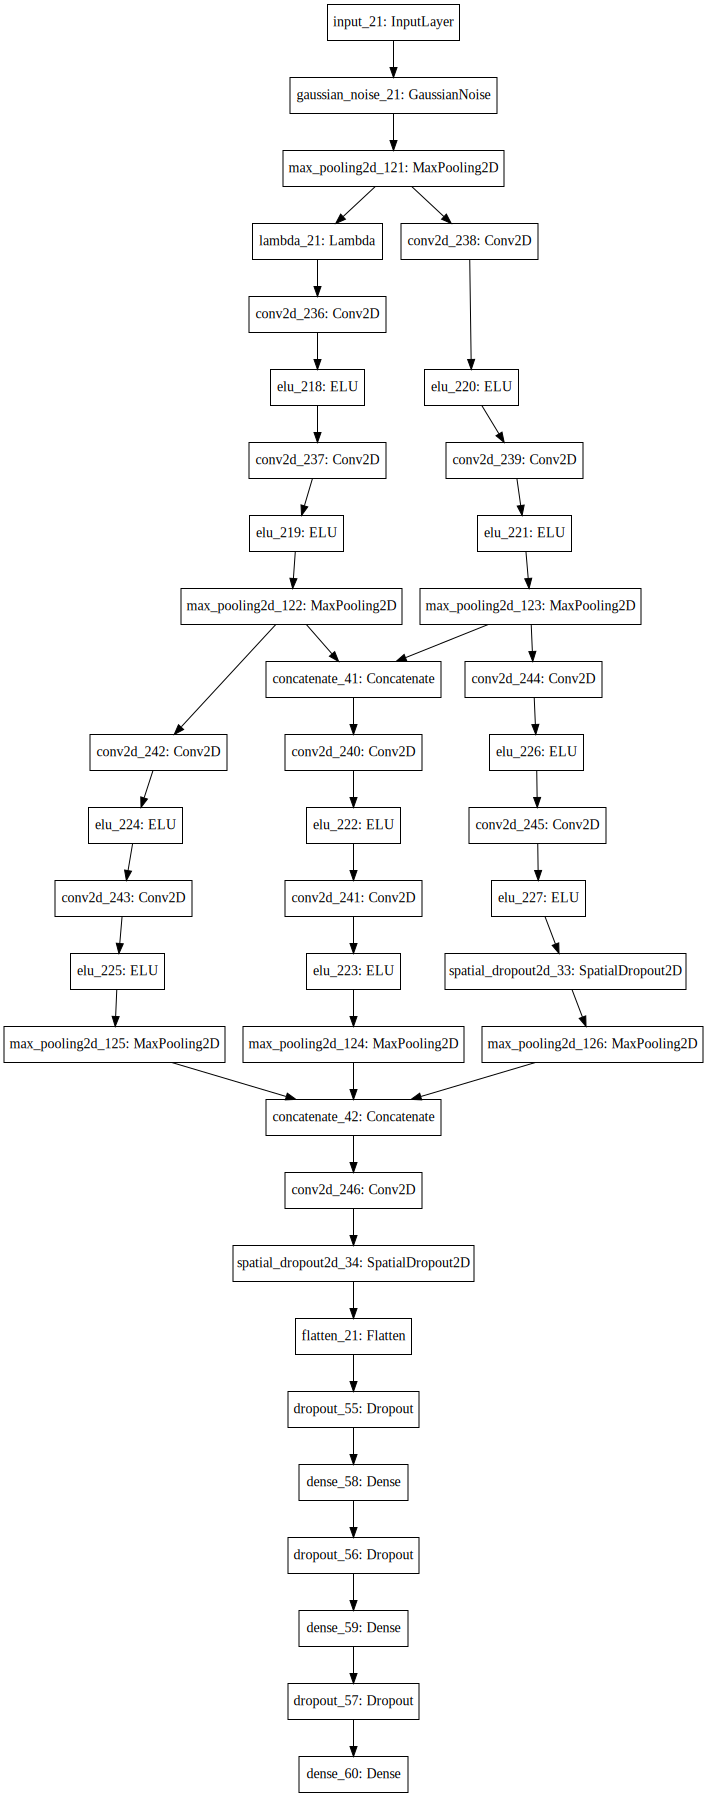

In [60]:
SVG(model_to_dot(model).create(prog = 'dot', format = 'svg'))

In [61]:
history = model.fit(X_train, Y_train, batch_size = 200, 
                    epochs = 100, verbose = 0,
                    validation_data = (X_test, Y_test),
                    callbacks = [TQDMNotebookCallback()])
print('Accuracy: ', model.evaluate(X_test, Y_test)[1] * 100.0, '%')

1265/1265 [==============================] - 6s 4ms/step
Accuracy:  60.632411090752825 %


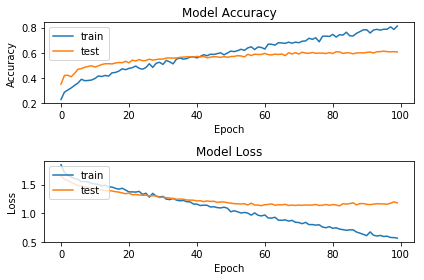

In [63]:
plt.figure(1)

# Accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

# Loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

plt.tight_layout()
plt.show()

In [62]:
model.save_weights('model_alt.weights')
model.save('model_alt.model')

In [64]:
preds = model.predict(X_test)

[94.75715     2.2561328   1.817821    0.9122858   0.12910114  0.12750377]
[1. 0. 0. 0. 0. 0.]


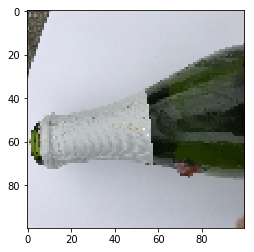

In [65]:
img = 10
np.set_printoptions(suppress = True)
print(preds[img] * 100.0)
print(Y_test[img])

plt.imshow(keras.preprocessing.image.array_to_img(X_test[img, :, :, :]))
plt.show()

#for a in Y_train:
#    print(a)

In [66]:
def getIndexOfHighestConfidence(pred):
    highestConfidenceIndex = 0
    for i in range(len(pred)):
        if pred[i] > pred[highestConfidenceIndex]:
            highestConfidenceIndex = i
    return highestConfidenceIndex

def getIndexOfClassification(test):
    classIndex = 0
    for i in range(len(test)):
        if test[i] == 1:
            classIndex = i
            break
    return classIndex

numCorrect = 0
for i in range(len(preds)):
    if getIndexOfHighestConfidence(preds[i]) == getIndexOfClassification(Y_test[i]):
        numCorrect = numCorrect + 1

percentCorrect = numCorrect / len(preds)
print(percentCorrect * 100.0)

60.63241106719368


In [67]:
# Glass, paper, cardboard, plastic, metal, trash
# For each category, let's see what the network would generally predict when it saw an image of that type
classCounts = [0, 0, 0, 0, 0, 0] # number of images for each category (from testing data)
predStats = [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]] 

for i in range(len(preds)):
    predictedClass = getIndexOfHighestConfidence(preds[i])
    actualClass = getIndexOfClassification(Y_test[i])
    
    classCounts[actualClass] = classCounts[actualClass] + 1
    predStats[actualClass][predictedClass] = predStats[actualClass][predictedClass] + 1

for i in range(6):
    for j in range(6):
        predStats[i][j] = (predStats[i][j] / classCounts[i]) * 100.0

#for i in range(6):
#    print(str((predStats[4][i] / 205) * 100.0))

In [69]:
classNames = ['Glass', 'Paper', 'Cardboard', 'Plastic', 'Metal', 'Trash']

print('Breakdown of network predictions for testing set:\n------------------------')
for i in range(6):
    print(classNames[i] + ':', classCounts[i], 'images')
    print('Network predictions given an image of', classNames[i] + ':')
    for j in range(6):
        print('\t' + classNames[j] + ':', str(np.round(predStats[i][j], 2)) + '%')
    print('\n')

Breakdown of network predictions for testing set:
------------------------
Glass: 251 images
Network predictions given an image of Glass:
	Glass: 71.71%
	Paper: 3.59%
	Cardboard: 4.38%
	Plastic: 6.37%
	Metal: 8.76%
	Trash: 5.18%


Paper: 297 images
Network predictions given an image of Paper:
	Glass: 12.46%
	Paper: 76.09%
	Cardboard: 3.03%
	Plastic: 1.68%
	Metal: 5.39%
	Trash: 1.35%


Cardboard: 202 images
Network predictions given an image of Cardboard:
	Glass: 15.84%
	Paper: 5.94%
	Cardboard: 66.34%
	Plastic: 3.96%
	Metal: 5.45%
	Trash: 2.48%


Plastic: 241 images
Network predictions given an image of Plastic:
	Glass: 24.48%
	Paper: 10.37%
	Cardboard: 8.3%
	Plastic: 46.89%
	Metal: 9.13%
	Trash: 0.83%


Metal: 205 images
Network predictions given an image of Metal:
	Glass: 32.2%
	Paper: 9.27%
	Cardboard: 6.34%
	Plastic: 7.32%
	Metal: 42.44%
	Trash: 2.44%


Trash: 69 images
Network predictions given an image of Trash:
	Glass: 34.78%
	Paper: 4.35%
	Cardboard: 7.25%
	Plastic: 8.7%
	Metal